# IF867 - Introdução à Aprendizagem Profunda
## 1ª atividade prática - 2025.1

Discente(s):
- Ana Sofia Lima (asosl)
- João Vitor Mergulhão (jvlm2)

## Instruções e requisitos
- Objetivo: Implementar e treinar um Multi-Layer Perceptron e uma Rede Neural Convolucional, inteiramente em PyTorch.
- Observação: A atividade pode ser feita em dupla.

## Tarefa

- Rede Neural Convolucional (CNN) (50% da nota):
  - Implementação: Proponha e construa sua própria arquitetura de CNN.
  - Implemente funções para o treinamento e avaliação do modelo.
  - Métricas e Análise:
    - Registre o tempo de treinamento de cada configuração.
    - Gere e apresente a matriz de confusão para os resultados da classificação.
    - Plote gráficos da função de loss e da acurácia ao longo das épocas de treinamento.
  - Experimentação:
    - Aplique e avalie técnicas de regularização (ex: Dropout, Batch Normalization).
    - Implemente e analise o Grad-CAM para visualização e interpretabilidade.
    - Explore outras técnicas relevantes para otimização ou análise de CNNs.
  - Relatório: Documente no notebook os experimentos realizados, as configurações utilizadas e os resultados obtidos, analisando o impacto de cada alteração.

O dataset escolhido foi o CIFAR10:
- Imagens 32x32
- composto por 10 classes

## Imports

In [ ]:
!pip install torchcam
!pip install opencv-python

In [1]:
import torch
from  torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchcam.methods import GradCAM

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset setup

In [2]:
# Define as transformações com data augmentation para o treinamento
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define as transformações sem data augmentation
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

train_val_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_val_dataset_plain = CIFAR10(root='./data', train=True, download=True, transform=val_test_transform)

# Extrai os rótulos
targets = np.array(train_val_dataset_plain.targets)

# Cria o validador estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Gera os índices
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(train_val_dataset, train_idx)     # com augmentation
    val_dataset = Subset(train_val_dataset_plain, val_idx)       # sem augmentation

# Dataset de teste também sem augmentation
test_dataset = CIFAR10(root='./data', train=False, download=False, transform=val_test_transform)

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32,
                                          shuffle = True, num_workers=2)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32,
                                          shuffle = False, num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32,
                                          shuffle = False, num_workers=2)

## Data visualization

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

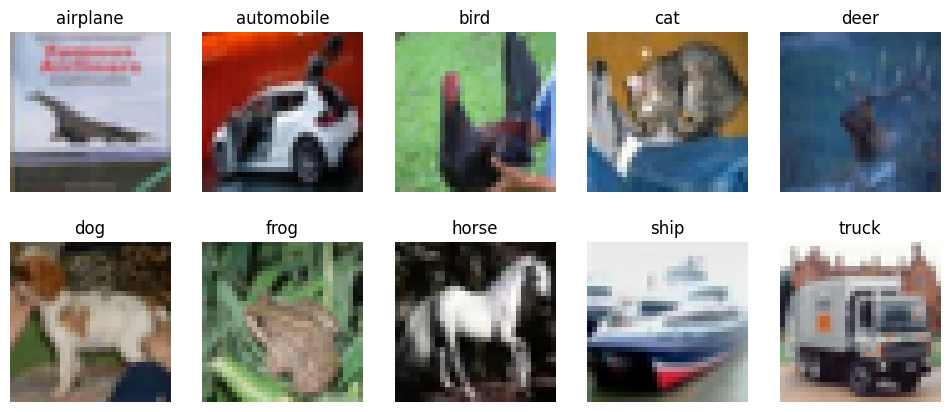

In [17]:
classes = test_dataset.classes

# Encontrar uma imagem de cada classe
images_per_class = {}
# Itera sobre o dataset até encontrar uma imagem para cada uma das 10 classes
for img, label in test_dataset:
    class_name = classes[label]
    if class_name not in images_per_class:
        images_per_class[class_name] = img
    # Para de procurar quando já tiver uma imagem de cada classe
    if len(images_per_class) == len(classes):
        break

# Criar uma figura para exibir as imagens
fig = plt.figure(figsize=(12, 5))

# Exibe uma imagem para cada classe
for i, class_name in enumerate(classes):
    ax = fig.add_subplot(2, 5, i + 1) # Cria uma grade 2x5 de subplots
    ax.set_title(class_name)
    imshow(images_per_class[class_name])

plt.show()

## Evaluation Functions

In [6]:
def evaluate(net, loader, loss_function):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
    net.train()
    return val_loss / len(loader)

In [7]:
def plotTrainVal(train_loss, val_loss, train_acc, val_acc):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Gráfico de Loss
    axes[0].plot(train_loss, label='Treinamento')
    axes[0].plot(val_loss, label='Validação')
    axes[0].set_title('Loss por Época')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Gráfico de Acurácia
    axes[1].plot(train_acc, label='Treinamento')
    axes[1].plot(val_acc, label='Validação')
    axes[1].set_title('Acurácia por Época')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Acurácia')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [8]:
def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [9]:
def makePredictions(net, test_loader):
  net.eval()
  predictions = []
  labels = []
  for images, label in test_loader:
    images = images.to(device)
    label = label.to(device)

    output = net(images)
    _, predicted = torch.max(output,1)

    predictions.extend(predicted.cpu().numpy())
    labels.extend(label.cpu().numpy())

  return labels, predictions

## CNN Definition

A arquitetura base para o projeto é uma versão simplificada da VGG. Com todos os kernels das convoluções com dimensão 3x3 e paddings = 1.

Também há a possibilidade de adicionar dropout nas camadas lineares e batch normalization entre as convoluções.

Detalhamento:

- Bloco 1:
    - Conv2d (3 -> 64)
    - ReLU
    - MaxPool2d(2, 2)
- Bloco 2:
    - Conv2d(64 → 128)
    - ReLU
    - Conv2d(128 → 128)
    - ReLU
    - MaxPool2d(2, 2)
- Bloco 3:
    - Conv2d(128 → 256)
    - ReLU
    - Conv2d(256 → 256)
    - ReLU
    - MaxPool2d(2, 2)

- Classificador:
    - Linear (4096 -> 128)
    - Relu
    - Linear (128 -> 64)
    - Relu
    - Linear (64 -> 10)

In [10]:
#Definir arquitetura da rede

# bloco convolucional -> convoluções seguidas de um max pool
def conv_block(num_convs, out_channels, batch_norm=False):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))

        # BatchNorm após convolução
        if batch_norm:
          layers.append(nn.LazyBatchNorm2d())

        layers.append(nn.ReLU())

    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

class CNN(nn.Module):
    def __init__(self, arch, num_classes=10, batch_norm=False, dropout=0.0):
        super().__init__()

        # camadas de convolução -> extração de features
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(conv_block(num_convs, out_channels, batch_norm))

        self.feature_extractor = nn.Sequential(*conv_blks)

        # Calcular a dimensão da saída do feature extractor automaticamente
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)
            dummy_output = self.feature_extractor(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]  # total de features

        # camadas completamente conectadas -> classificação
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


## Train Loop

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(net, train_loader, val_loader, criterion, optimizer, device, num_epochs=20, patience=3):
    net.to(device)

    train_losses = []
    val_losses = []

    train_acc = []
    val_acc = []

    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in tqdm(range(num_epochs)):
        net.train()
        epoch_loss = 0.0
        train_correct = 0
        train_total = 0

        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            train_total += 1

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()     

            if (i + 1) % 1000 == 0:
              tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Step {i + 1}/{len(train_loader)}, Loss: {loss:.4f}')

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(epoch_loss / len(train_loader))
        train_acc.append(train_correct / train_total)

        # Validação
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_correct = 0
            val_total = 0

            for inputs, labels in val_loader:
                val_total += 1
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc.append(val_correct / val_total)

        tqdm.write(f'Epoch {epoch+1} completed. Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_state = net.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                tqdm.write(f"Early stopping at epoch {epoch+1}")
                break

    # Restaura melhor modelo encontrado
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    return net, train_losses, val_losses, train_acc, val_acc

## Experiment 1

Modelo treinado sem nenhuma técnica de regularização

 | Métrica              | Valor     |
|----------------------|-----------|
| Acurácia             | 0.83    |
| Acurácia Balanceada  | 0.83    |
| Precisão             | 0.832    |
| Recal                | 0.83   |
| F1-Score             | 0.83   |

- Treinou por 31 épocas até o early stopping
- 6 minutos e 30 segundos -> média de 12,58 s por época

In [18]:
# Hiperparâmetros
arch=((1, 64),
      (2, 128),
      (2, 256))

batch_size = 32
learning_rate = 1e-3
dropout = 0
batch_norm = False
num_epochs=40
patience=5

In [19]:
#instancia a rede
net = CNN(arch=((1, 64), (2, 128), (2, 256)))
net.to(device)

#função de perda (loss)
criterion = nn.CrossEntropyLoss()

#otimizador
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [20]:
net, train_losses, val_losses, train_acc, val_acc = train_model(net, 
                                                                train_loader, 
                                                                val_loader, 
                                                                criterion, 
                                                                optimizer, 
                                                                device, 
                                                                num_epochs=num_epochs, 
                                                                patience=patience)

# salvar o modelo treinado
torch.save(net.state_dict(), "best_model_exp1.pth")

  0%|          | 0/40 [00:08<?, ?it/s]

Epoch 1/40, Step 1000/1250, Loss: 1.7314


  2%|▎         | 1/40 [00:12<08:18, 12.79s/it]

Epoch 1 completed. Train Loss: 1.7305 | Val Loss: 1.4852


  2%|▎         | 1/40 [00:21<08:18, 12.79s/it]

Epoch 2/40, Step 1000/1250, Loss: 1.2287


  5%|▌         | 2/40 [00:25<08:01, 12.66s/it]

Epoch 2 completed. Train Loss: 1.3152 | Val Loss: 1.1496


  5%|▌         | 2/40 [00:34<08:01, 12.66s/it]

Epoch 3/40, Step 1000/1250, Loss: 1.1796


  8%|▊         | 3/40 [00:38<07:48, 12.67s/it]

Epoch 3 completed. Train Loss: 1.1162 | Val Loss: 0.9743


  8%|▊         | 3/40 [00:46<07:48, 12.67s/it]

Epoch 4/40, Step 1000/1250, Loss: 0.8194


 10%|█         | 4/40 [00:50<07:32, 12.56s/it]

Epoch 4 completed. Train Loss: 0.9814 | Val Loss: 0.9184


 10%|█         | 4/40 [00:59<07:32, 12.56s/it]

Epoch 5/40, Step 1000/1250, Loss: 1.3915


 12%|█▎        | 5/40 [01:03<07:21, 12.63s/it]

Epoch 5 completed. Train Loss: 0.8858 | Val Loss: 0.8103


 12%|█▎        | 5/40 [01:11<07:21, 12.63s/it]

Epoch 6/40, Step 1000/1250, Loss: 1.1335


 15%|█▌        | 6/40 [01:15<07:10, 12.67s/it]

Epoch 6 completed. Train Loss: 0.8133 | Val Loss: 0.7671


 15%|█▌        | 6/40 [01:24<07:10, 12.67s/it]

Epoch 7/40, Step 1000/1250, Loss: 0.7723


 18%|█▊        | 7/40 [01:28<07:01, 12.76s/it]

Epoch 7 completed. Train Loss: 0.7546 | Val Loss: 0.7270


 18%|█▊        | 7/40 [01:37<07:01, 12.76s/it]

Epoch 8/40, Step 1000/1250, Loss: 0.5277


 20%|██        | 8/40 [01:41<06:44, 12.64s/it]

Epoch 8 completed. Train Loss: 0.7036 | Val Loss: 0.7088


 20%|██        | 8/40 [01:49<06:44, 12.64s/it]

Epoch 9/40, Step 1000/1250, Loss: 0.8211


 22%|██▎       | 9/40 [01:53<06:30, 12.61s/it]

Epoch 9 completed. Train Loss: 0.6592 | Val Loss: 0.6627


 22%|██▎       | 9/40 [02:02<06:30, 12.61s/it]

Epoch 10/40, Step 1000/1250, Loss: 0.7162


 25%|██▌       | 10/40 [02:06<06:16, 12.55s/it]

Epoch 10 completed. Train Loss: 0.6288 | Val Loss: 0.6506


 25%|██▌       | 10/40 [02:14<06:16, 12.55s/it]

Epoch 11/40, Step 1000/1250, Loss: 0.6057


 28%|██▊       | 11/40 [02:19<06:06, 12.63s/it]

Epoch 11 completed. Train Loss: 0.5988 | Val Loss: 0.6144


 28%|██▊       | 11/40 [02:28<06:06, 12.63s/it]

Epoch 12/40, Step 1000/1250, Loss: 0.5619


 30%|███       | 12/40 [02:32<05:57, 12.77s/it]

Epoch 12 completed. Train Loss: 0.5776 | Val Loss: 0.6517


 30%|███       | 12/40 [02:40<05:57, 12.77s/it]

Epoch 13/40, Step 1000/1250, Loss: 0.6011


 32%|███▎      | 13/40 [02:44<05:41, 12.65s/it]

Epoch 13 completed. Train Loss: 0.5562 | Val Loss: 0.6471


 32%|███▎      | 13/40 [02:52<05:41, 12.65s/it]

Epoch 14/40, Step 1000/1250, Loss: 0.8440


 35%|███▌      | 14/40 [02:56<05:27, 12.59s/it]

Epoch 14 completed. Train Loss: 0.5352 | Val Loss: 0.6182


 35%|███▌      | 14/40 [03:05<05:27, 12.59s/it]

Epoch 15/40, Step 1000/1250, Loss: 0.5070


 38%|███▊      | 15/40 [03:09<05:13, 12.56s/it]

Epoch 15 completed. Train Loss: 0.5214 | Val Loss: 0.6161


 38%|███▊      | 15/40 [03:17<05:13, 12.56s/it]

Epoch 16/40, Step 1000/1250, Loss: 0.5007


 40%|████      | 16/40 [03:21<05:00, 12.52s/it]

Epoch 16 completed. Train Loss: 0.5032 | Val Loss: 0.6028


 40%|████      | 16/40 [03:30<05:00, 12.52s/it]

Epoch 17/40, Step 1000/1250, Loss: 0.4007


 42%|████▎     | 17/40 [03:34<04:48, 12.55s/it]

Epoch 17 completed. Train Loss: 0.4885 | Val Loss: 0.5833


 42%|████▎     | 17/40 [03:43<04:48, 12.55s/it]

Epoch 18/40, Step 1000/1250, Loss: 0.6347


 45%|████▌     | 18/40 [03:47<04:36, 12.57s/it]

Epoch 18 completed. Train Loss: 0.4756 | Val Loss: 0.6026


 45%|████▌     | 18/40 [03:55<04:36, 12.57s/it]

Epoch 19/40, Step 1000/1250, Loss: 0.2098


 48%|████▊     | 19/40 [03:59<04:23, 12.55s/it]

Epoch 19 completed. Train Loss: 0.4711 | Val Loss: 0.6204


 48%|████▊     | 19/40 [04:08<04:23, 12.55s/it]

Epoch 20/40, Step 1000/1250, Loss: 0.5042


 50%|█████     | 20/40 [04:11<04:09, 12.49s/it]

Epoch 20 completed. Train Loss: 0.4574 | Val Loss: 0.6343


 50%|█████     | 20/40 [04:20<04:09, 12.49s/it]

Epoch 21/40, Step 1000/1250, Loss: 0.4537


 52%|█████▎    | 21/40 [04:24<03:58, 12.57s/it]

Epoch 21 completed. Train Loss: 0.4495 | Val Loss: 0.5654


 52%|█████▎    | 21/40 [04:33<03:58, 12.57s/it]

Epoch 22/40, Step 1000/1250, Loss: 0.2953


 55%|█████▌    | 22/40 [04:37<03:46, 12.56s/it]

Epoch 22 completed. Train Loss: 0.4315 | Val Loss: 0.6071


 55%|█████▌    | 22/40 [04:45<03:46, 12.56s/it]

Epoch 23/40, Step 1000/1250, Loss: 0.4748


 57%|█████▊    | 23/40 [04:49<03:33, 12.56s/it]

Epoch 23 completed. Train Loss: 0.4252 | Val Loss: 0.6276


 57%|█████▊    | 23/40 [04:58<03:33, 12.56s/it]

Epoch 24/40, Step 1000/1250, Loss: 0.4097


 60%|██████    | 24/40 [05:02<03:20, 12.52s/it]

Epoch 24 completed. Train Loss: 0.4178 | Val Loss: 0.5919


 60%|██████    | 24/40 [05:10<03:20, 12.52s/it]

Epoch 25/40, Step 1000/1250, Loss: 0.3976


 62%|██████▎   | 25/40 [05:14<03:07, 12.52s/it]

Epoch 25 completed. Train Loss: 0.4080 | Val Loss: 0.5787


 62%|██████▎   | 25/40 [05:23<03:07, 12.52s/it]

Epoch 26/40, Step 1000/1250, Loss: 0.4036


 65%|██████▌   | 26/40 [05:27<02:55, 12.53s/it]

Epoch 26 completed. Train Loss: 0.3956 | Val Loss: 0.5424


 65%|██████▌   | 26/40 [05:35<02:55, 12.53s/it]

Epoch 27/40, Step 1000/1250, Loss: 0.3491


 68%|██████▊   | 27/40 [05:39<02:42, 12.51s/it]

Epoch 27 completed. Train Loss: 0.3916 | Val Loss: 0.5765


 68%|██████▊   | 27/40 [05:48<02:42, 12.51s/it]

Epoch 28/40, Step 1000/1250, Loss: 0.1882


 70%|███████   | 28/40 [05:52<02:30, 12.52s/it]

Epoch 28 completed. Train Loss: 0.3880 | Val Loss: 0.5670


 70%|███████   | 28/40 [06:00<02:30, 12.52s/it]

Epoch 29/40, Step 1000/1250, Loss: 0.3950


 72%|███████▎  | 29/40 [06:04<02:18, 12.57s/it]

Epoch 29 completed. Train Loss: 0.3733 | Val Loss: 0.5486


 72%|███████▎  | 29/40 [06:13<02:18, 12.57s/it]

Epoch 30/40, Step 1000/1250, Loss: 0.7563


 75%|███████▌  | 30/40 [06:17<02:05, 12.56s/it]

Epoch 30 completed. Train Loss: 0.3743 | Val Loss: 0.5542


 75%|███████▌  | 30/40 [06:26<02:05, 12.56s/it]

Epoch 31/40, Step 1000/1250, Loss: 0.2516


 75%|███████▌  | 30/40 [06:30<02:10, 13.01s/it]

Epoch 31 completed. Train Loss: 0.3661 | Val Loss: 0.5513
Early stopping at epoch 31


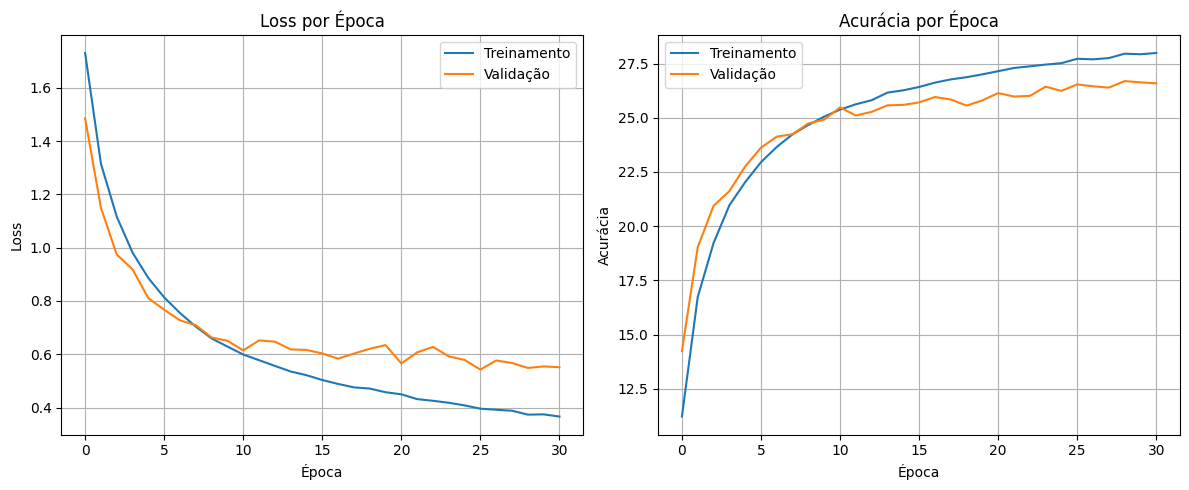

In [21]:
plotTrainVal(train_losses, val_losses, train_acc, val_acc)

In [22]:
targets, predictions = makePredictions(net, test_loader)

get_scores(targets, predictions)

{'accuracy': 0.8302,
 'balanced_accuracy': 0.8301999999999999,
 'precision': 0.831940794215268,
 'recall': 0.8302,
 'f1_score': 0.8296036036289275}

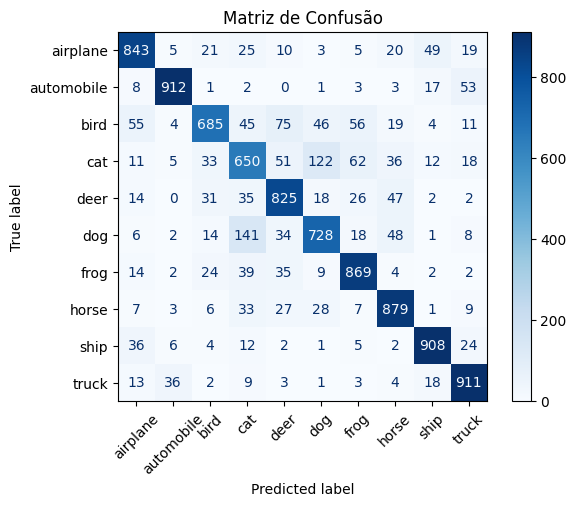

In [ ]:
cm = confusion_matrix(targets, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Experiment 2: Batch Normalization

Neste experimento foram realizadas operações de batch normalizations após cada convolução.

| Métrica              | Valor     |
|----------------------|-----------|
| Acurácia             | 0.865    |
| Acurácia Balanceada  | 0.865    |
| Precisão             | 0.867    |
| Recall   | 0.865    |
| F1-Score             | 0.864    |

- Treinou por 26 épocas até o early stopping
- 4 minutos e 47 segundos -> média de 12,48 s por época

In [25]:
# Hiperparâmetros
arch=((1, 64),
      (2, 128),
      (2, 256))

batch_size = 32
learning_rate = 1e-3
dropout = 0
batch_norm = True
num_epochs=40
patience=5

In [26]:
#instancia a rede
net = CNN(arch=((1, 64), (2, 128), (2, 256)), batch_norm=batch_norm)
net.to(device)

#função de perda (loss)
criterion = nn.CrossEntropyLoss()

#otimizador
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [27]:
net, train_losses, val_losses, train_acc, val_acc = train_model(net, 
                                                                train_loader, 
                                                                val_loader, 
                                                                criterion, 
                                                                optimizer, 
                                                                device, 
                                                                num_epochs=num_epochs, 
                                                                patience=patience)

# salvar o modelo treinado
torch.save(net.state_dict(), "best_model_exp2.pth")

  0%|          | 0/40 [00:08<?, ?it/s]

Epoch 1/40, Step 1000/1250, Loss: 1.4967


  2%|▎         | 1/40 [00:12<08:10, 12.58s/it]

Epoch 1 completed. Train Loss: 1.5152 | Val Loss: 1.2629


  2%|▎         | 1/40 [00:21<08:10, 12.58s/it]

Epoch 2/40, Step 1000/1250, Loss: 0.9357


  5%|▌         | 2/40 [00:25<07:54, 12.49s/it]

Epoch 2 completed. Train Loss: 1.1175 | Val Loss: 0.9971


  5%|▌         | 2/40 [00:33<07:54, 12.49s/it]

Epoch 3/40, Step 1000/1250, Loss: 0.9467


  8%|▊         | 3/40 [00:37<07:41, 12.46s/it]

Epoch 3 completed. Train Loss: 0.9375 | Val Loss: 0.8398


  8%|▊         | 3/40 [00:45<07:41, 12.46s/it]

Epoch 4/40, Step 1000/1250, Loss: 0.8835


 10%|█         | 4/40 [00:49<07:29, 12.49s/it]

Epoch 4 completed. Train Loss: 0.8148 | Val Loss: 0.7764


 10%|█         | 4/40 [00:58<07:29, 12.49s/it]

Epoch 5/40, Step 1000/1250, Loss: 0.7123


 12%|█▎        | 5/40 [01:02<07:15, 12.46s/it]

Epoch 5 completed. Train Loss: 0.7255 | Val Loss: 0.6902


 12%|█▎        | 5/40 [01:11<07:15, 12.46s/it]

Epoch 6/40, Step 1000/1250, Loss: 0.9820


 15%|█▌        | 6/40 [01:15<07:05, 12.53s/it]

Epoch 6 completed. Train Loss: 0.6647 | Val Loss: 0.7202


 15%|█▌        | 6/40 [01:23<07:05, 12.53s/it]

Epoch 7/40, Step 1000/1250, Loss: 0.6897


 18%|█▊        | 7/40 [01:27<06:49, 12.41s/it]

Epoch 7 completed. Train Loss: 0.6051 | Val Loss: 0.6379


 18%|█▊        | 7/40 [01:35<06:49, 12.41s/it]

Epoch 8/40, Step 1000/1250, Loss: 0.4229


 20%|██        | 8/40 [01:39<06:37, 12.42s/it]

Epoch 8 completed. Train Loss: 0.5562 | Val Loss: 0.5899


 20%|██        | 8/40 [01:48<06:37, 12.42s/it]

Epoch 9/40, Step 1000/1250, Loss: 0.4129


 22%|██▎       | 9/40 [01:52<06:25, 12.44s/it]

Epoch 9 completed. Train Loss: 0.5156 | Val Loss: 0.4999


 22%|██▎       | 9/40 [02:00<06:25, 12.44s/it]

Epoch 10/40, Step 1000/1250, Loss: 0.2879


 25%|██▌       | 10/40 [02:04<06:13, 12.45s/it]

Epoch 10 completed. Train Loss: 0.4794 | Val Loss: 0.4982


 25%|██▌       | 10/40 [02:13<06:13, 12.45s/it]

Epoch 11/40, Step 1000/1250, Loss: 0.7905


 28%|██▊       | 11/40 [02:16<05:59, 12.38s/it]

Epoch 11 completed. Train Loss: 0.4490 | Val Loss: 0.4981


 28%|██▊       | 11/40 [02:25<05:59, 12.38s/it]

Epoch 12/40, Step 1000/1250, Loss: 0.7123


 30%|███       | 12/40 [02:29<05:48, 12.46s/it]

Epoch 12 completed. Train Loss: 0.4203 | Val Loss: 0.4776


 30%|███       | 12/40 [02:37<05:48, 12.46s/it]

Epoch 13/40, Step 1000/1250, Loss: 0.5381


 32%|███▎      | 13/40 [02:41<05:36, 12.47s/it]

Epoch 13 completed. Train Loss: 0.4015 | Val Loss: 0.5073


 32%|███▎      | 13/40 [02:50<05:36, 12.47s/it]

Epoch 14/40, Step 1000/1250, Loss: 0.4172


 35%|███▌      | 14/40 [02:54<05:25, 12.50s/it]

Epoch 14 completed. Train Loss: 0.3727 | Val Loss: 0.4590


 35%|███▌      | 14/40 [03:03<05:25, 12.50s/it]

Epoch 15/40, Step 1000/1250, Loss: 0.0920


 38%|███▊      | 15/40 [03:07<05:13, 12.52s/it]

Epoch 15 completed. Train Loss: 0.3503 | Val Loss: 0.4886


 38%|███▊      | 15/40 [03:15<05:13, 12.52s/it]

Epoch 16/40, Step 1000/1250, Loss: 0.5964


 40%|████      | 16/40 [03:19<04:59, 12.46s/it]

Epoch 16 completed. Train Loss: 0.3369 | Val Loss: 0.4778


 40%|████      | 16/40 [03:27<04:59, 12.46s/it]

Epoch 17/40, Step 1000/1250, Loss: 0.3886


 42%|████▎     | 17/40 [03:31<04:47, 12.48s/it]

Epoch 17 completed. Train Loss: 0.3147 | Val Loss: 0.4339


 42%|████▎     | 17/40 [03:40<04:47, 12.48s/it]

Epoch 18/40, Step 1000/1250, Loss: 0.1472


 45%|████▌     | 18/40 [03:44<04:34, 12.48s/it]

Epoch 18 completed. Train Loss: 0.2973 | Val Loss: 0.4089


 45%|████▌     | 18/40 [03:53<04:34, 12.48s/it]

Epoch 19/40, Step 1000/1250, Loss: 0.1508


 48%|████▊     | 19/40 [03:57<04:23, 12.53s/it]

Epoch 19 completed. Train Loss: 0.2788 | Val Loss: 0.4176


 48%|████▊     | 19/40 [04:05<04:23, 12.53s/it]

Epoch 20/40, Step 1000/1250, Loss: 0.1864


 50%|█████     | 20/40 [04:09<04:11, 12.59s/it]

Epoch 20 completed. Train Loss: 0.2634 | Val Loss: 0.4142


 50%|█████     | 20/40 [04:18<04:11, 12.59s/it]

Epoch 21/40, Step 1000/1250, Loss: 0.1819


 52%|█████▎    | 21/40 [04:22<03:59, 12.60s/it]

Epoch 21 completed. Train Loss: 0.2518 | Val Loss: 0.4241


 52%|█████▎    | 21/40 [04:31<03:59, 12.60s/it]

Epoch 22/40, Step 1000/1250, Loss: 0.1955


 55%|█████▌    | 22/40 [04:35<03:47, 12.64s/it]

Epoch 22 completed. Train Loss: 0.2368 | Val Loss: 0.4416


 55%|█████▌    | 22/40 [04:43<03:47, 12.64s/it]

Epoch 23/40, Step 1000/1250, Loss: 0.4128


 55%|█████▌    | 22/40 [04:47<03:55, 13.08s/it]

Epoch 23 completed. Train Loss: 0.2308 | Val Loss: 0.4242
Early stopping at epoch 23


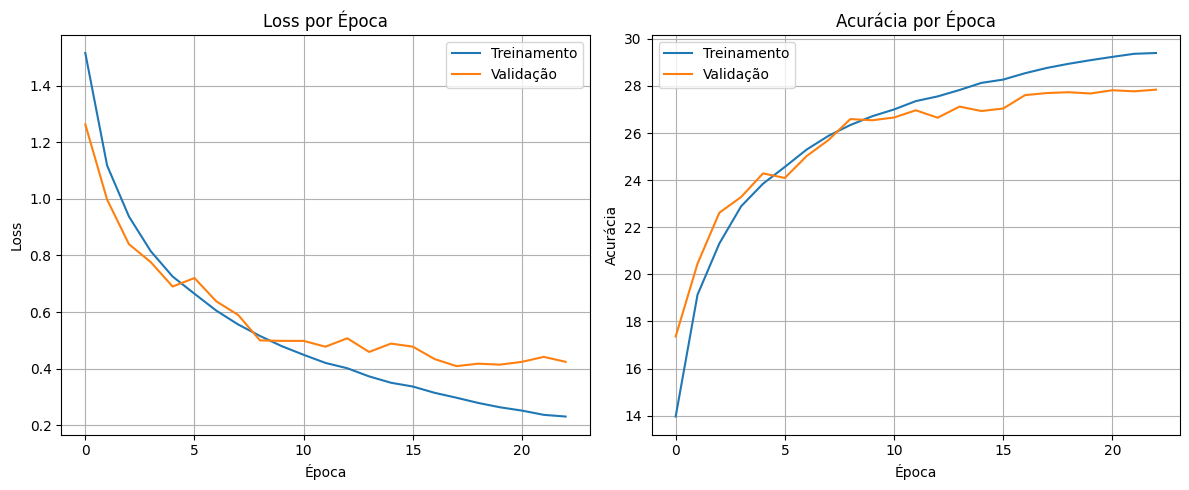

In [28]:
plotTrainVal(train_losses, val_losses, train_acc, val_acc)

In [29]:
targets, predictions = makePredictions(net, test_loader)

get_scores(targets, predictions)

{'accuracy': 0.8649,
 'balanced_accuracy': 0.8649000000000001,
 'precision': 0.8656450167109222,
 'recall': 0.8649,
 'f1_score': 0.8644301456211193}

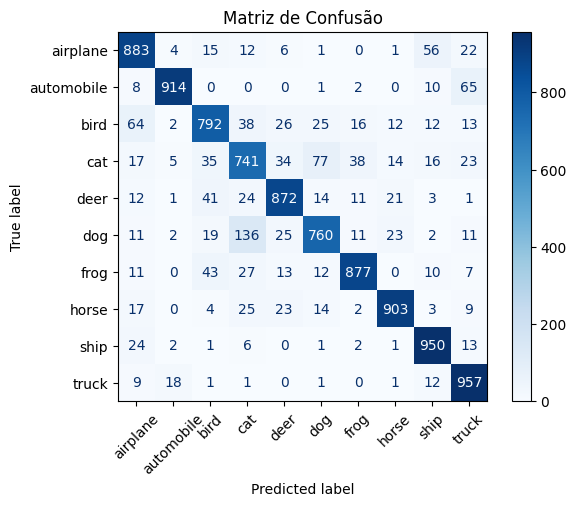

In [30]:
cm = confusion_matrix(targets, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Experiment 3: Dropout

| Métrica              | Valor     |
|----------------------|-----------|
| Acurácia             | 0.798    |
| Acurácia Balanceada  | 0.798    |
| Precisão             | 0.8    |
| Recall   | 0.798    |
| F1-Score             | 0.798    |

- Treinou por 40 épocas e não acionou o early stopping
- 8 minutos e 19 segundos -> média de 12,47 s por época

In [33]:
# Hiperparâmetros
arch=((1, 64),
      (2, 128),
      (2, 256))

batch_size = 32
learning_rate = 1e-3
dropout = 0.4 # <---- porcentagem de dropout de 40%
batch_norm = False
num_epochs=40
patience=5

In [34]:
#instancia a rede
net = CNN(arch=((1, 64), (2, 128), (2, 256)), dropout=dropout)
net.to(device)

#função de perda (loss)
criterion = nn.CrossEntropyLoss()

#otimizador
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [35]:
net, train_losses, val_losses, train_acc, val_acc = train_model(net, 
                                                                train_loader, 
                                                                val_loader, 
                                                                criterion, 
                                                                optimizer, 
                                                                device, 
                                                                num_epochs=num_epochs, 
                                                                patience=patience)

# salvar o modelo treinado
torch.save(net.state_dict(), "best_model_exp3.pth")

  0%|          | 0/40 [00:08<?, ?it/s]

Epoch 1/40, Step 1000/1250, Loss: 1.9484


  2%|▎         | 1/40 [00:12<08:17, 12.75s/it]

Epoch 1 completed. Train Loss: 1.9231 | Val Loss: 1.5758


  2%|▎         | 1/40 [00:21<08:17, 12.75s/it]

Epoch 2/40, Step 1000/1250, Loss: 1.4796


  5%|▌         | 2/40 [00:25<07:59, 12.62s/it]

Epoch 2 completed. Train Loss: 1.5812 | Val Loss: 1.3527


  5%|▌         | 2/40 [00:33<07:59, 12.62s/it]

Epoch 3/40, Step 1000/1250, Loss: 1.3935


  8%|▊         | 3/40 [00:37<07:43, 12.52s/it]

Epoch 3 completed. Train Loss: 1.4110 | Val Loss: 1.2594


  8%|▊         | 3/40 [00:46<07:43, 12.52s/it]

Epoch 4/40, Step 1000/1250, Loss: 1.1600


 10%|█         | 4/40 [00:50<07:29, 12.49s/it]

Epoch 4 completed. Train Loss: 1.2852 | Val Loss: 1.0962


 10%|█         | 4/40 [00:58<07:29, 12.49s/it]

Epoch 5/40, Step 1000/1250, Loss: 1.3103


 12%|█▎        | 5/40 [01:02<07:18, 12.52s/it]

Epoch 5 completed. Train Loss: 1.2025 | Val Loss: 1.0839


 12%|█▎        | 5/40 [01:11<07:18, 12.52s/it]

Epoch 6/40, Step 1000/1250, Loss: 1.0870


 15%|█▌        | 6/40 [01:15<07:04, 12.48s/it]

Epoch 6 completed. Train Loss: 1.1398 | Val Loss: 1.0150


 15%|█▌        | 6/40 [01:23<07:04, 12.48s/it]

Epoch 7/40, Step 1000/1250, Loss: 0.5465


 18%|█▊        | 7/40 [01:27<06:52, 12.51s/it]

Epoch 7 completed. Train Loss: 1.0819 | Val Loss: 0.9669


 18%|█▊        | 7/40 [01:36<06:52, 12.51s/it]

Epoch 8/40, Step 1000/1250, Loss: 0.9235


 20%|██        | 8/40 [01:40<06:40, 12.53s/it]

Epoch 8 completed. Train Loss: 1.0455 | Val Loss: 0.9527


 20%|██        | 8/40 [01:48<06:40, 12.53s/it]

Epoch 9/40, Step 1000/1250, Loss: 0.9791


 22%|██▎       | 9/40 [01:52<06:28, 12.54s/it]

Epoch 9 completed. Train Loss: 1.0096 | Val Loss: 0.9041


 22%|██▎       | 9/40 [02:01<06:28, 12.54s/it]

Epoch 10/40, Step 1000/1250, Loss: 0.7368


 25%|██▌       | 10/40 [02:05<06:15, 12.52s/it]

Epoch 10 completed. Train Loss: 0.9757 | Val Loss: 0.8752


 25%|██▌       | 10/40 [02:13<06:15, 12.52s/it]

Epoch 11/40, Step 1000/1250, Loss: 0.9286


 28%|██▊       | 11/40 [02:18<06:05, 12.59s/it]

Epoch 11 completed. Train Loss: 0.9439 | Val Loss: 0.8366


 28%|██▊       | 11/40 [02:26<06:05, 12.59s/it]

Epoch 12/40, Step 1000/1250, Loss: 0.8150


 30%|███       | 12/40 [02:30<05:52, 12.57s/it]

Epoch 12 completed. Train Loss: 0.9222 | Val Loss: 0.8365


 30%|███       | 12/40 [02:39<05:52, 12.57s/it]

Epoch 13/40, Step 1000/1250, Loss: 0.8980


 32%|███▎      | 13/40 [02:43<05:39, 12.56s/it]

Epoch 13 completed. Train Loss: 0.8998 | Val Loss: 0.7980


 32%|███▎      | 13/40 [02:51<05:39, 12.56s/it]

Epoch 14/40, Step 1000/1250, Loss: 1.0101


 35%|███▌      | 14/40 [02:55<05:28, 12.64s/it]

Epoch 14 completed. Train Loss: 0.8789 | Val Loss: 0.7586


 35%|███▌      | 14/40 [03:04<05:28, 12.64s/it]

Epoch 15/40, Step 1000/1250, Loss: 0.8836


 38%|███▊      | 15/40 [03:08<05:15, 12.61s/it]

Epoch 15 completed. Train Loss: 0.8447 | Val Loss: 0.7676


 38%|███▊      | 15/40 [03:17<05:15, 12.61s/it]

Epoch 16/40, Step 1000/1250, Loss: 0.6767


 40%|████      | 16/40 [03:21<05:03, 12.66s/it]

Epoch 16 completed. Train Loss: 0.8450 | Val Loss: 0.7837


 40%|████      | 16/40 [03:29<05:03, 12.66s/it]

Epoch 17/40, Step 1000/1250, Loss: 0.6671


 42%|████▎     | 17/40 [03:33<04:50, 12.62s/it]

Epoch 17 completed. Train Loss: 0.8233 | Val Loss: 0.7904


 42%|████▎     | 17/40 [03:42<04:50, 12.62s/it]

Epoch 18/40, Step 1000/1250, Loss: 0.7974


 45%|████▌     | 18/40 [03:46<04:38, 12.64s/it]

Epoch 18 completed. Train Loss: 0.8050 | Val Loss: 0.7425


 45%|████▌     | 18/40 [03:54<04:38, 12.64s/it]

Epoch 19/40, Step 1000/1250, Loss: 1.0505


 48%|████▊     | 19/40 [03:58<04:24, 12.60s/it]

Epoch 19 completed. Train Loss: 0.8042 | Val Loss: 0.7416


 48%|████▊     | 19/40 [04:08<04:24, 12.60s/it]

Epoch 20/40, Step 1000/1250, Loss: 0.7934


 50%|█████     | 20/40 [04:12<04:16, 12.80s/it]

Epoch 20 completed. Train Loss: 0.7870 | Val Loss: 0.7345


 50%|█████     | 20/40 [04:20<04:16, 12.80s/it]

Epoch 21/40, Step 1000/1250, Loss: 0.4688


 52%|█████▎    | 21/40 [04:24<04:00, 12.64s/it]

Epoch 21 completed. Train Loss: 0.7634 | Val Loss: 0.7053


 52%|█████▎    | 21/40 [04:32<04:00, 12.64s/it]

Epoch 22/40, Step 1000/1250, Loss: 0.8012


 55%|█████▌    | 22/40 [04:36<03:45, 12.55s/it]

Epoch 22 completed. Train Loss: 0.7615 | Val Loss: 0.6918


 55%|█████▌    | 22/40 [04:45<03:45, 12.55s/it]

Epoch 23/40, Step 1000/1250, Loss: 0.8517


 57%|█████▊    | 23/40 [04:49<03:32, 12.52s/it]

Epoch 23 completed. Train Loss: 0.7408 | Val Loss: 0.7378


 57%|█████▊    | 23/40 [04:57<03:32, 12.52s/it]

Epoch 24/40, Step 1000/1250, Loss: 0.4408


 60%|██████    | 24/40 [05:01<03:19, 12.49s/it]

Epoch 24 completed. Train Loss: 0.7301 | Val Loss: 0.7135


 60%|██████    | 24/40 [05:10<03:19, 12.49s/it]

Epoch 25/40, Step 1000/1250, Loss: 0.9407


 62%|██████▎   | 25/40 [05:14<03:07, 12.48s/it]

Epoch 25 completed. Train Loss: 0.7168 | Val Loss: 0.7101


 62%|██████▎   | 25/40 [05:22<03:07, 12.48s/it]

Epoch 26/40, Step 1000/1250, Loss: 0.7148


 65%|██████▌   | 26/40 [05:26<02:55, 12.54s/it]

Epoch 26 completed. Train Loss: 0.7161 | Val Loss: 0.6830


 65%|██████▌   | 26/40 [05:35<02:55, 12.54s/it]

Epoch 27/40, Step 1000/1250, Loss: 0.8321


 68%|██████▊   | 27/40 [05:39<02:43, 12.60s/it]

Epoch 27 completed. Train Loss: 0.7084 | Val Loss: 0.6958


 68%|██████▊   | 27/40 [05:48<02:43, 12.60s/it]

Epoch 28/40, Step 1000/1250, Loss: 0.6582


 70%|███████   | 28/40 [05:51<02:30, 12.50s/it]

Epoch 28 completed. Train Loss: 0.7032 | Val Loss: 0.6698


 70%|███████   | 28/40 [06:00<02:30, 12.50s/it]

Epoch 29/40, Step 1000/1250, Loss: 0.5781


 72%|███████▎  | 29/40 [06:04<02:17, 12.46s/it]

Epoch 29 completed. Train Loss: 0.7002 | Val Loss: 0.6842


 72%|███████▎  | 29/40 [06:12<02:17, 12.46s/it]

Epoch 30/40, Step 1000/1250, Loss: 1.1997


 75%|███████▌  | 30/40 [06:16<02:04, 12.41s/it]

Epoch 30 completed. Train Loss: 0.6807 | Val Loss: 0.7336


 75%|███████▌  | 30/40 [06:25<02:04, 12.41s/it]

Epoch 31/40, Step 1000/1250, Loss: 0.6710


 78%|███████▊  | 31/40 [06:29<01:52, 12.51s/it]

Epoch 31 completed. Train Loss: 0.6793 | Val Loss: 0.6602


 78%|███████▊  | 31/40 [06:37<01:52, 12.51s/it]

Epoch 32/40, Step 1000/1250, Loss: 0.7199


 80%|████████  | 32/40 [06:41<01:39, 12.45s/it]

Epoch 32 completed. Train Loss: 0.6689 | Val Loss: 0.6662


 80%|████████  | 32/40 [06:50<01:39, 12.45s/it]

Epoch 33/40, Step 1000/1250, Loss: 0.8172


 82%|████████▎ | 33/40 [06:53<01:26, 12.41s/it]

Epoch 33 completed. Train Loss: 0.6674 | Val Loss: 0.6650


 82%|████████▎ | 33/40 [07:02<01:26, 12.41s/it]

Epoch 34/40, Step 1000/1250, Loss: 0.5168


 85%|████████▌ | 34/40 [07:06<01:14, 12.42s/it]

Epoch 34 completed. Train Loss: 0.6616 | Val Loss: 0.6913


 85%|████████▌ | 34/40 [07:14<01:14, 12.42s/it]

Epoch 35/40, Step 1000/1250, Loss: 0.6185


 88%|████████▊ | 35/40 [07:18<01:01, 12.39s/it]

Epoch 35 completed. Train Loss: 0.6573 | Val Loss: 0.6309


 88%|████████▊ | 35/40 [07:27<01:01, 12.39s/it]

Epoch 36/40, Step 1000/1250, Loss: 0.8277


 90%|█████████ | 36/40 [07:31<00:49, 12.48s/it]

Epoch 36 completed. Train Loss: 0.6456 | Val Loss: 0.6260


 90%|█████████ | 36/40 [07:39<00:49, 12.48s/it]

Epoch 37/40, Step 1000/1250, Loss: 0.7480


 92%|█████████▎| 37/40 [07:43<00:37, 12.36s/it]

Epoch 37 completed. Train Loss: 0.6392 | Val Loss: 0.6642


 92%|█████████▎| 37/40 [07:51<00:37, 12.36s/it]

Epoch 38/40, Step 1000/1250, Loss: 0.4824


 95%|█████████▌| 38/40 [07:55<00:24, 12.25s/it]

Epoch 38 completed. Train Loss: 0.6366 | Val Loss: 0.6604


 95%|█████████▌| 38/40 [08:03<00:24, 12.25s/it]

Epoch 39/40, Step 1000/1250, Loss: 0.4355


 98%|█████████▊| 39/40 [08:07<00:12, 12.24s/it]

Epoch 39 completed. Train Loss: 0.6407 | Val Loss: 0.6768


 98%|█████████▊| 39/40 [08:15<00:12, 12.24s/it]

Epoch 40/40, Step 1000/1250, Loss: 0.8964


100%|██████████| 40/40 [08:19<00:00, 12.49s/it]

Epoch 40 completed. Train Loss: 0.6331 | Val Loss: 0.6256


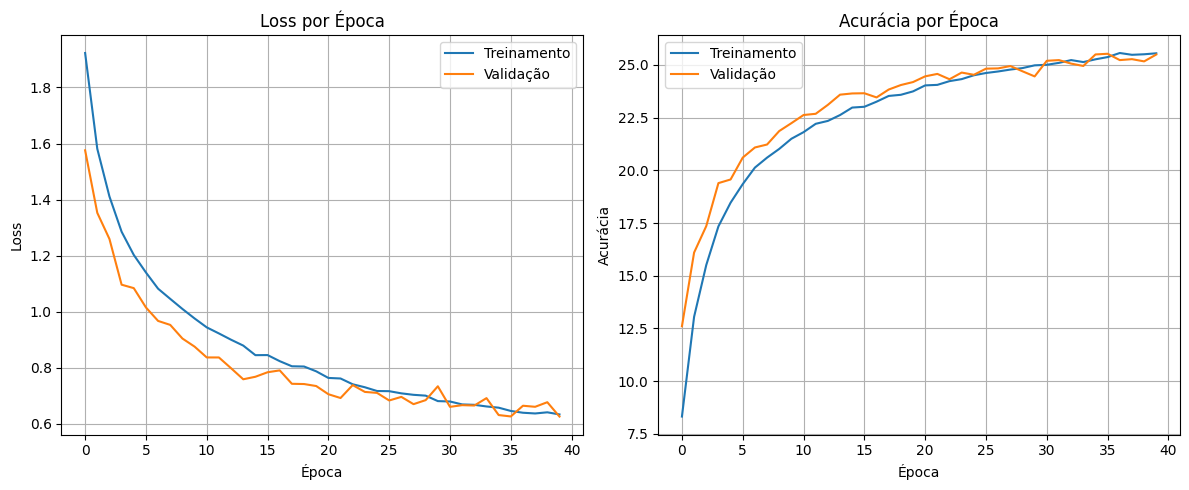

In [36]:
plotTrainVal(train_losses, val_losses, train_acc, val_acc)

In [37]:
targets, predictions = makePredictions(net, test_loader)

get_scores(targets, predictions)

{'accuracy': 0.798,
 'balanced_accuracy': 0.798,
 'precision': 0.8004188018635968,
 'recall': 0.798,
 'f1_score': 0.7977813620517868}

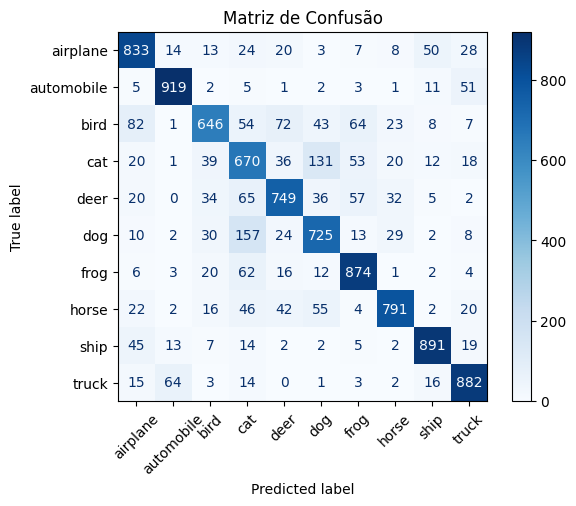

In [38]:
cm = confusion_matrix(targets, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Experiment 4: Weight decay

- Treinou 38 épocas até o early stopping
- 7 minutos e 55 segundos -> 12,5 segundos por época

| Métrica              | Valor     |
|----------------------|-----------|
| Acurácia             | 0.8    |
| Acurácia Balanceada  | 0.8   |
| Precisão             | 0.809   |
| Recall   | 0.8    |
| F1-Score             | 0.8    |

In [ ]:
# Hiperparâmetros
arch=((1, 64),
      (2, 128),
      (2, 256))

batch_size = 32
learning_rate = 1e-3
dropout = 0 
batch_norm = False
num_epochs=40
patience=5
weight_decay = 1e-4 # <--- valor usado para a regularização

In [ ]:
#instancia a rede
net = CNN(arch=((1, 64), (2, 128), (2, 256)))
net.to(device)

#função de perda (loss)
criterion = nn.CrossEntropyLoss()

#otimizador
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
net, train_losses, val_losses, train_acc, val_acc = train_model(net, 
                                                                train_loader, 
                                                                val_loader, 
                                                                criterion, 
                                                                optimizer, 
                                                                device, 
                                                                num_epochs=num_epochs, 
                                                                patience=patience)

# salvar o modelo treinado
torch.save(net.state_dict(), "best_model_exp4.pth")

  0%|          | 0/40 [00:08<?, ?it/s]

Epoch 1/40, Step 1000/1250, Loss: 1.9824


  2%|▎         | 1/40 [00:12<08:13, 12.66s/it]

Epoch 1 completed. Train Loss: 1.7866 | Val Loss: 1.4844


  2%|▎         | 1/40 [00:21<08:13, 12.66s/it]

Epoch 2/40, Step 1000/1250, Loss: 1.6816


  5%|▌         | 2/40 [00:25<08:03, 12.73s/it]

Epoch 2 completed. Train Loss: 1.4332 | Val Loss: 1.2288


  5%|▌         | 2/40 [00:33<08:03, 12.73s/it]

Epoch 3/40, Step 1000/1250, Loss: 1.1986


  8%|▊         | 3/40 [00:37<07:45, 12.59s/it]

Epoch 3 completed. Train Loss: 1.2456 | Val Loss: 1.1177


  8%|▊         | 3/40 [00:46<07:45, 12.59s/it]

Epoch 4/40, Step 1000/1250, Loss: 0.9772


 10%|█         | 4/40 [00:50<07:32, 12.57s/it]

Epoch 4 completed. Train Loss: 1.1036 | Val Loss: 1.0155


 10%|█         | 4/40 [00:59<07:32, 12.57s/it]

Epoch 5/40, Step 1000/1250, Loss: 1.1739


 12%|█▎        | 5/40 [01:02<07:19, 12.54s/it]

Epoch 5 completed. Train Loss: 0.9974 | Val Loss: 0.9774


 12%|█▎        | 5/40 [01:11<07:19, 12.54s/it]

Epoch 6/40, Step 1000/1250, Loss: 0.8342


 15%|█▌        | 6/40 [01:15<07:07, 12.57s/it]

Epoch 6 completed. Train Loss: 0.9132 | Val Loss: 0.8568


 15%|█▌        | 6/40 [01:24<07:07, 12.57s/it]

Epoch 7/40, Step 1000/1250, Loss: 0.9297


 18%|█▊        | 7/40 [01:28<06:54, 12.57s/it]

Epoch 7 completed. Train Loss: 0.8480 | Val Loss: 0.8186


 18%|█▊        | 7/40 [01:36<06:54, 12.57s/it]

Epoch 8/40, Step 1000/1250, Loss: 0.7696


 20%|██        | 8/40 [01:40<06:41, 12.54s/it]

Epoch 8 completed. Train Loss: 0.7884 | Val Loss: 0.7612


 20%|██        | 8/40 [01:49<06:41, 12.54s/it]

Epoch 9/40, Step 1000/1250, Loss: 0.7379


 22%|██▎       | 9/40 [01:53<06:28, 12.53s/it]

Epoch 9 completed. Train Loss: 0.7548 | Val Loss: 0.7549


 22%|██▎       | 9/40 [02:01<06:28, 12.53s/it]

Epoch 10/40, Step 1000/1250, Loss: 0.7107


 25%|██▌       | 10/40 [02:05<06:16, 12.56s/it]

Epoch 10 completed. Train Loss: 0.7228 | Val Loss: 0.7289


 25%|██▌       | 10/40 [02:14<06:16, 12.56s/it]

Epoch 11/40, Step 1000/1250, Loss: 0.7358


 28%|██▊       | 11/40 [02:18<06:02, 12.50s/it]

Epoch 11 completed. Train Loss: 0.6945 | Val Loss: 0.6794


 28%|██▊       | 11/40 [02:26<06:02, 12.50s/it]

Epoch 12/40, Step 1000/1250, Loss: 0.7097


 30%|███       | 12/40 [02:30<05:52, 12.58s/it]

Epoch 12 completed. Train Loss: 0.6678 | Val Loss: 0.6730


 30%|███       | 12/40 [02:39<05:52, 12.58s/it]

Epoch 13/40, Step 1000/1250, Loss: 0.6157


 32%|███▎      | 13/40 [02:43<05:37, 12.49s/it]

Epoch 13 completed. Train Loss: 0.6498 | Val Loss: 0.6469


 32%|███▎      | 13/40 [02:51<05:37, 12.49s/it]

Epoch 14/40, Step 1000/1250, Loss: 0.6540


 35%|███▌      | 14/40 [02:55<05:25, 12.53s/it]

Epoch 14 completed. Train Loss: 0.6294 | Val Loss: 0.6226


 35%|███▌      | 14/40 [03:04<05:25, 12.53s/it]

Epoch 15/40, Step 1000/1250, Loss: 0.6227


 38%|███▊      | 15/40 [03:08<05:11, 12.46s/it]

Epoch 15 completed. Train Loss: 0.6142 | Val Loss: 0.6127


 38%|███▊      | 15/40 [03:16<05:11, 12.46s/it]

Epoch 16/40, Step 1000/1250, Loss: 0.4541


 40%|████      | 16/40 [03:20<04:58, 12.45s/it]

Epoch 16 completed. Train Loss: 0.6023 | Val Loss: 0.6371


 40%|████      | 16/40 [03:28<04:58, 12.45s/it]

Epoch 17/40, Step 1000/1250, Loss: 0.4504


 42%|████▎     | 17/40 [03:33<04:47, 12.50s/it]

Epoch 17 completed. Train Loss: 0.5852 | Val Loss: 0.6042


 42%|████▎     | 17/40 [03:41<04:47, 12.50s/it]

Epoch 18/40, Step 1000/1250, Loss: 0.5718


 45%|████▌     | 18/40 [03:45<04:35, 12.51s/it]

Epoch 18 completed. Train Loss: 0.5693 | Val Loss: 0.6508


 45%|████▌     | 18/40 [03:54<04:35, 12.51s/it]

Epoch 19/40, Step 1000/1250, Loss: 0.7862


 48%|████▊     | 19/40 [03:58<04:22, 12.52s/it]

Epoch 19 completed. Train Loss: 0.5646 | Val Loss: 0.6080


 48%|████▊     | 19/40 [04:06<04:22, 12.52s/it]

Epoch 20/40, Step 1000/1250, Loss: 0.8859


 50%|█████     | 20/40 [04:10<04:09, 12.50s/it]

Epoch 20 completed. Train Loss: 0.5471 | Val Loss: 0.5950


 50%|█████     | 20/40 [04:19<04:09, 12.50s/it]

Epoch 21/40, Step 1000/1250, Loss: 0.8336


 52%|█████▎    | 21/40 [04:22<03:56, 12.46s/it]

Epoch 21 completed. Train Loss: 0.5430 | Val Loss: 0.5822


 52%|█████▎    | 21/40 [04:31<03:56, 12.46s/it]

Epoch 22/40, Step 1000/1250, Loss: 0.3155


 55%|█████▌    | 22/40 [04:35<03:44, 12.49s/it]

Epoch 22 completed. Train Loss: 0.5346 | Val Loss: 0.5809


 55%|█████▌    | 22/40 [04:43<03:44, 12.49s/it]

Epoch 23/40, Step 1000/1250, Loss: 0.7281


 57%|█████▊    | 23/40 [04:47<03:31, 12.44s/it]

Epoch 23 completed. Train Loss: 0.5305 | Val Loss: 0.5844


 57%|█████▊    | 23/40 [04:56<03:31, 12.44s/it]

Epoch 24/40, Step 1000/1250, Loss: 0.4618


 60%|██████    | 24/40 [05:00<03:19, 12.48s/it]

Epoch 24 completed. Train Loss: 0.5228 | Val Loss: 0.5816


 60%|██████    | 24/40 [05:09<03:19, 12.48s/it]

Epoch 25/40, Step 1000/1250, Loss: 0.5949


 62%|██████▎   | 25/40 [05:13<03:08, 12.57s/it]

Epoch 25 completed. Train Loss: 0.5143 | Val Loss: 0.5744


 62%|██████▎   | 25/40 [05:21<03:08, 12.57s/it]

Epoch 26/40, Step 1000/1250, Loss: 0.6094


 65%|██████▌   | 26/40 [05:25<02:55, 12.53s/it]

Epoch 26 completed. Train Loss: 0.5077 | Val Loss: 0.5992


 65%|██████▌   | 26/40 [05:34<02:55, 12.53s/it]

Epoch 27/40, Step 1000/1250, Loss: 0.8411


 68%|██████▊   | 27/40 [05:38<02:43, 12.56s/it]

Epoch 27 completed. Train Loss: 0.4937 | Val Loss: 0.5595


 68%|██████▊   | 27/40 [05:46<02:43, 12.56s/it]

Epoch 28/40, Step 1000/1250, Loss: 0.5592


 70%|███████   | 28/40 [05:50<02:30, 12.58s/it]

Epoch 28 completed. Train Loss: 0.4972 | Val Loss: 0.5543


 70%|███████   | 28/40 [05:59<02:30, 12.58s/it]

Epoch 29/40, Step 1000/1250, Loss: 0.3210


 72%|███████▎  | 29/40 [06:03<02:17, 12.49s/it]

Epoch 29 completed. Train Loss: 0.4932 | Val Loss: 0.5641


 72%|███████▎  | 29/40 [06:11<02:17, 12.49s/it]

Epoch 30/40, Step 1000/1250, Loss: 0.3508


 75%|███████▌  | 30/40 [06:15<02:04, 12.48s/it]

Epoch 30 completed. Train Loss: 0.4801 | Val Loss: 0.5285


 75%|███████▌  | 30/40 [06:24<02:04, 12.48s/it]

Epoch 31/40, Step 1000/1250, Loss: 0.4795


 78%|███████▊  | 31/40 [06:28<01:52, 12.49s/it]

Epoch 31 completed. Train Loss: 0.4764 | Val Loss: 0.5462


 78%|███████▊  | 31/40 [06:36<01:52, 12.49s/it]

Epoch 32/40, Step 1000/1250, Loss: 0.5778


 80%|████████  | 32/40 [06:40<01:39, 12.43s/it]

Epoch 32 completed. Train Loss: 0.4680 | Val Loss: 0.5540


 80%|████████  | 32/40 [06:48<01:39, 12.43s/it]

Epoch 33/40, Step 1000/1250, Loss: 0.6238


 82%|████████▎ | 33/40 [06:52<01:26, 12.37s/it]

Epoch 33 completed. Train Loss: 0.4667 | Val Loss: 0.5128


 82%|████████▎ | 33/40 [07:01<01:26, 12.37s/it]

Epoch 34/40, Step 1000/1250, Loss: 0.5626


 85%|████████▌ | 34/40 [07:05<01:14, 12.46s/it]

Epoch 34 completed. Train Loss: 0.4611 | Val Loss: 0.6312


 85%|████████▌ | 34/40 [07:13<01:14, 12.46s/it]

Epoch 35/40, Step 1000/1250, Loss: 0.4623


 88%|████████▊ | 35/40 [07:17<01:02, 12.44s/it]

Epoch 35 completed. Train Loss: 0.4614 | Val Loss: 0.5264


 88%|████████▊ | 35/40 [07:26<01:02, 12.44s/it]

Epoch 36/40, Step 1000/1250, Loss: 0.5185


 90%|█████████ | 36/40 [07:30<00:50, 12.51s/it]

Epoch 36 completed. Train Loss: 0.4586 | Val Loss: 0.5588


 90%|█████████ | 36/40 [07:38<00:50, 12.51s/it]

Epoch 37/40, Step 1000/1250, Loss: 0.3834


 92%|█████████▎| 37/40 [07:42<00:37, 12.48s/it]

Epoch 37 completed. Train Loss: 0.4535 | Val Loss: 0.5637


 92%|█████████▎| 37/40 [07:51<00:37, 12.48s/it]

Epoch 38/40, Step 1000/1250, Loss: 0.3205


 92%|█████████▎| 37/40 [07:55<00:38, 12.85s/it]

Epoch 38 completed. Train Loss: 0.4461 | Val Loss: 0.6064
Early stopping at epoch 38


In [ ]:
targets, predictions = makePredictions(net, test_loader)

get_scores(targets, predictions)

{'accuracy': 0.8002,
 'balanced_accuracy': 0.8001999999999999,
 'precision': 0.8093255602874627,
 'recall': 0.8002,
 'f1_score': 0.8001546694182297}

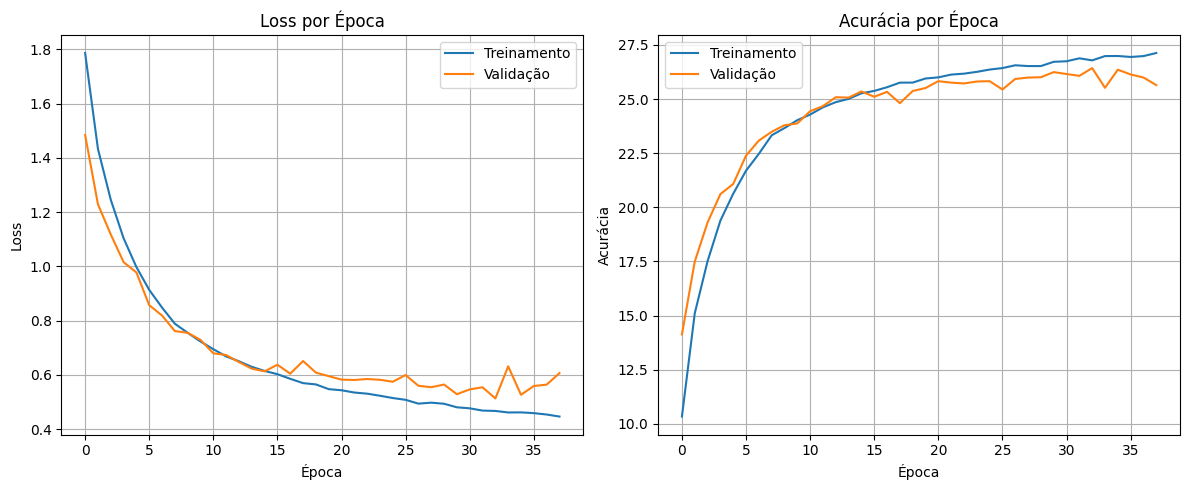

In [ ]:
plotTrainVal(train_losses, val_losses, train_acc, val_acc)

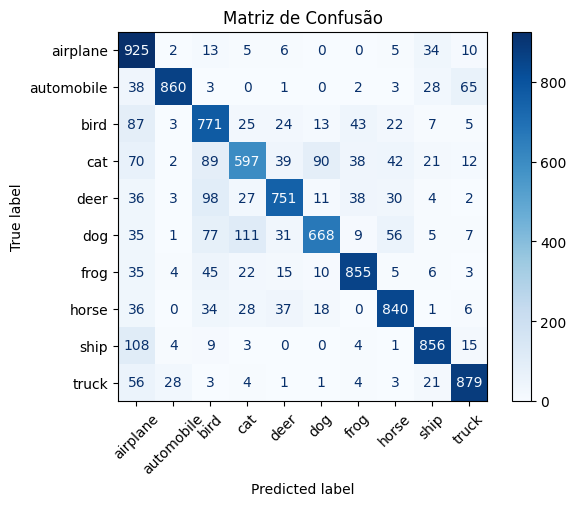

In [ ]:
cm = confusion_matrix(targets, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Experiment 5: Tudo junto

Esse experimento aplica todas as técnicas de regularização testadas nos experimentos anteriores:

- Batch normalization
- Dropout de 40%
- Weight_decay com coeficiente 1e-4

 | Métrica              | Valor     |
|----------------------|-----------|
| Acurácia             | 0.862    |
| Acurácia Balanceada  | 0.862     |
| Precisão             | 0.862    |
| Recal                | 0.862    |
| F1-Score             | 0.861    |

- Treinou por 34 épocas até o early stopping
- 7 minutos e 4 segundos -> 12,47 segundos por época

In [12]:
# Hiperparâmetros
arch=((1, 64),
      (2, 128),
      (2, 256))

batch_size = 32
learning_rate = 1e-3
dropout = 0.4 
batch_norm = True 
num_epochs=40
patience=5
weight_decay = 1e-4 # <--- valor usado para a regularização

In [13]:
#instancia a rede
net = CNN(arch=((1, 64), (2, 128), (2, 256)), batch_norm=batch_norm, dropout=dropout)
net.to(device)

#função de perda (loss)
criterion = nn.CrossEntropyLoss()

#otimizador
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [14]:
net, train_losses, val_losses, train_acc, val_acc = train_model(net, 
                                                                train_loader, 
                                                                val_loader, 
                                                                criterion, 
                                                                optimizer, 
                                                                device, 
                                                                num_epochs=num_epochs, 
                                                                patience=patience)

# salvar o modelo treinado
torch.save(net.state_dict(), "best_model_exp5.pth")

  0%|          | 0/40 [00:10<?, ?it/s]

Epoch 1/40, Step 1000/1250, Loss: 1.6240


  2%|▎         | 1/40 [00:14<09:17, 14.30s/it]

Epoch 1 completed. Train Loss: 1.8221 | Val Loss: 1.4915


  2%|▎         | 1/40 [00:23<09:17, 14.30s/it]

Epoch 2/40, Step 1000/1250, Loss: 1.7256


  5%|▌         | 2/40 [00:27<08:36, 13.60s/it]

Epoch 2 completed. Train Loss: 1.5382 | Val Loss: 1.2722


  5%|▌         | 2/40 [00:36<08:36, 13.60s/it]

Epoch 3/40, Step 1000/1250, Loss: 1.1693


  8%|▊         | 3/40 [00:40<08:12, 13.31s/it]

Epoch 3 completed. Train Loss: 1.3606 | Val Loss: 1.1631


  8%|▊         | 3/40 [00:49<08:12, 13.31s/it]

Epoch 4/40, Step 1000/1250, Loss: 1.3667


 10%|█         | 4/40 [00:53<07:57, 13.27s/it]

Epoch 4 completed. Train Loss: 1.2259 | Val Loss: 1.0925


 10%|█         | 4/40 [01:01<07:57, 13.27s/it]

Epoch 5/40, Step 1000/1250, Loss: 0.9375


 12%|█▎        | 5/40 [01:05<07:30, 12.88s/it]

Epoch 5 completed. Train Loss: 1.1190 | Val Loss: 0.9276


 12%|█▎        | 5/40 [01:14<07:30, 12.88s/it]

Epoch 6/40, Step 1000/1250, Loss: 0.6707


 15%|█▌        | 6/40 [01:18<07:12, 12.72s/it]

Epoch 6 completed. Train Loss: 1.0462 | Val Loss: 0.8243


 15%|█▌        | 6/40 [01:26<07:12, 12.72s/it]

Epoch 7/40, Step 1000/1250, Loss: 0.8813


 18%|█▊        | 7/40 [01:30<06:57, 12.65s/it]

Epoch 7 completed. Train Loss: 0.9577 | Val Loss: 0.7445


 18%|█▊        | 7/40 [01:39<06:57, 12.65s/it]

Epoch 8/40, Step 1000/1250, Loss: 0.7118


 20%|██        | 8/40 [01:43<06:45, 12.67s/it]

Epoch 8 completed. Train Loss: 0.8920 | Val Loss: 0.6945


 20%|██        | 8/40 [01:51<06:45, 12.67s/it]

Epoch 9/40, Step 1000/1250, Loss: 0.9588


 22%|██▎       | 9/40 [01:55<06:28, 12.53s/it]

Epoch 9 completed. Train Loss: 0.8210 | Val Loss: 0.7238


 22%|██▎       | 9/40 [02:04<06:28, 12.53s/it]

Epoch 10/40, Step 1000/1250, Loss: 0.5206


 25%|██▌       | 10/40 [02:08<06:15, 12.51s/it]

Epoch 10 completed. Train Loss: 0.7672 | Val Loss: 0.6616


 25%|██▌       | 10/40 [02:16<06:15, 12.51s/it]

Epoch 11/40, Step 1000/1250, Loss: 0.5943


 28%|██▊       | 11/40 [02:20<06:03, 12.54s/it]

Epoch 11 completed. Train Loss: 0.7204 | Val Loss: 0.5924


 28%|██▊       | 11/40 [02:29<06:03, 12.54s/it]

Epoch 12/40, Step 1000/1250, Loss: 0.7506


 30%|███       | 12/40 [02:33<05:49, 12.49s/it]

Epoch 12 completed. Train Loss: 0.6704 | Val Loss: 0.6023


 30%|███       | 12/40 [02:41<05:49, 12.49s/it]

Epoch 13/40, Step 1000/1250, Loss: 0.6316


 32%|███▎      | 13/40 [02:45<05:33, 12.37s/it]

Epoch 13 completed. Train Loss: 0.6366 | Val Loss: 0.5373


 32%|███▎      | 13/40 [02:53<05:33, 12.37s/it]

Epoch 14/40, Step 1000/1250, Loss: 0.8024


 35%|███▌      | 14/40 [02:57<05:21, 12.38s/it]

Epoch 14 completed. Train Loss: 0.6155 | Val Loss: 0.5811


 35%|███▌      | 14/40 [03:05<05:21, 12.38s/it]

Epoch 15/40, Step 1000/1250, Loss: 0.7020


 38%|███▊      | 15/40 [03:09<05:07, 12.31s/it]

Epoch 15 completed. Train Loss: 0.5839 | Val Loss: 0.5147


 38%|███▊      | 15/40 [03:18<05:07, 12.31s/it]

Epoch 16/40, Step 1000/1250, Loss: 0.4464


 40%|████      | 16/40 [03:21<04:55, 12.30s/it]

Epoch 16 completed. Train Loss: 0.5562 | Val Loss: 0.4989


 40%|████      | 16/40 [03:30<04:55, 12.30s/it]

Epoch 17/40, Step 1000/1250, Loss: 0.3667


 42%|████▎     | 17/40 [03:34<04:42, 12.29s/it]

Epoch 17 completed. Train Loss: 0.5340 | Val Loss: 0.5332


 42%|████▎     | 17/40 [03:42<04:42, 12.29s/it]

Epoch 18/40, Step 1000/1250, Loss: 0.2998


 45%|████▌     | 18/40 [03:46<04:30, 12.29s/it]

Epoch 18 completed. Train Loss: 0.5116 | Val Loss: 0.4598


 45%|████▌     | 18/40 [03:55<04:30, 12.29s/it]

Epoch 19/40, Step 1000/1250, Loss: 0.5659


 48%|████▊     | 19/40 [03:58<04:18, 12.29s/it]

Epoch 19 completed. Train Loss: 0.4979 | Val Loss: 0.4891


 48%|████▊     | 19/40 [04:07<04:18, 12.29s/it]

Epoch 20/40, Step 1000/1250, Loss: 0.4011


 50%|█████     | 20/40 [04:11<04:06, 12.32s/it]

Epoch 20 completed. Train Loss: 0.4838 | Val Loss: 0.4708


 50%|█████     | 20/40 [04:19<04:06, 12.32s/it]

Epoch 21/40, Step 1000/1250, Loss: 0.2849


 52%|█████▎    | 21/40 [04:23<03:54, 12.36s/it]

Epoch 21 completed. Train Loss: 0.4638 | Val Loss: 0.4603


 52%|█████▎    | 21/40 [04:32<03:54, 12.36s/it]

Epoch 22/40, Step 1000/1250, Loss: 0.4381


 55%|█████▌    | 22/40 [04:36<03:42, 12.35s/it]

Epoch 22 completed. Train Loss: 0.4561 | Val Loss: 0.4447


 55%|█████▌    | 22/40 [04:44<03:42, 12.35s/it]

Epoch 23/40, Step 1000/1250, Loss: 0.4692


 57%|█████▊    | 23/40 [04:48<03:30, 12.37s/it]

Epoch 23 completed. Train Loss: 0.4459 | Val Loss: 0.4624


 57%|█████▊    | 23/40 [04:56<03:30, 12.37s/it]

Epoch 24/40, Step 1000/1250, Loss: 0.4575


 60%|██████    | 24/40 [05:00<03:17, 12.33s/it]

Epoch 24 completed. Train Loss: 0.4371 | Val Loss: 0.4592


 60%|██████    | 24/40 [05:09<03:17, 12.33s/it]

Epoch 25/40, Step 1000/1250, Loss: 0.2481


 62%|██████▎   | 25/40 [05:13<03:05, 12.34s/it]

Epoch 25 completed. Train Loss: 0.4263 | Val Loss: 0.4376


 62%|██████▎   | 25/40 [05:21<03:05, 12.34s/it]

Epoch 26/40, Step 1000/1250, Loss: 0.2037


 65%|██████▌   | 26/40 [05:25<02:52, 12.31s/it]

Epoch 26 completed. Train Loss: 0.4185 | Val Loss: 0.4438


 65%|██████▌   | 26/40 [05:33<02:52, 12.31s/it]

Epoch 27/40, Step 1000/1250, Loss: 0.5333


 68%|██████▊   | 27/40 [05:37<02:40, 12.36s/it]

Epoch 27 completed. Train Loss: 0.4035 | Val Loss: 0.4429


 68%|██████▊   | 27/40 [05:46<02:40, 12.36s/it]

Epoch 28/40, Step 1000/1250, Loss: 0.3019


 70%|███████   | 28/40 [05:50<02:27, 12.33s/it]

Epoch 28 completed. Train Loss: 0.4012 | Val Loss: 0.4994


 70%|███████   | 28/40 [05:58<02:27, 12.33s/it]

Epoch 29/40, Step 1000/1250, Loss: 0.2159


 72%|███████▎  | 29/40 [06:02<02:15, 12.31s/it]

Epoch 29 completed. Train Loss: 0.3994 | Val Loss: 0.4367


 72%|███████▎  | 29/40 [06:10<02:15, 12.31s/it]

Epoch 30/40, Step 1000/1250, Loss: 0.4831


 75%|███████▌  | 30/40 [06:14<02:02, 12.27s/it]

Epoch 30 completed. Train Loss: 0.3884 | Val Loss: 0.4948


 75%|███████▌  | 30/40 [06:22<02:02, 12.27s/it]

Epoch 31/40, Step 1000/1250, Loss: 0.2772


 78%|███████▊  | 31/40 [06:26<01:50, 12.24s/it]

Epoch 31 completed. Train Loss: 0.3860 | Val Loss: 0.4943


 78%|███████▊  | 31/40 [06:34<01:50, 12.24s/it]

Epoch 32/40, Step 1000/1250, Loss: 0.3868


 80%|████████  | 32/40 [06:38<01:37, 12.23s/it]

Epoch 32 completed. Train Loss: 0.3782 | Val Loss: 0.4545


 80%|████████  | 32/40 [06:47<01:37, 12.23s/it]

Epoch 33/40, Step 1000/1250, Loss: 0.3508


 82%|████████▎ | 33/40 [06:51<01:25, 12.25s/it]

Epoch 33 completed. Train Loss: 0.3742 | Val Loss: 0.4517


 82%|████████▎ | 33/40 [06:59<01:25, 12.25s/it]

Epoch 34/40, Step 1000/1250, Loss: 0.2816


 82%|████████▎ | 33/40 [07:03<01:29, 12.84s/it]

Epoch 34 completed. Train Loss: 0.3629 | Val Loss: 0.4469
Early stopping at epoch 34


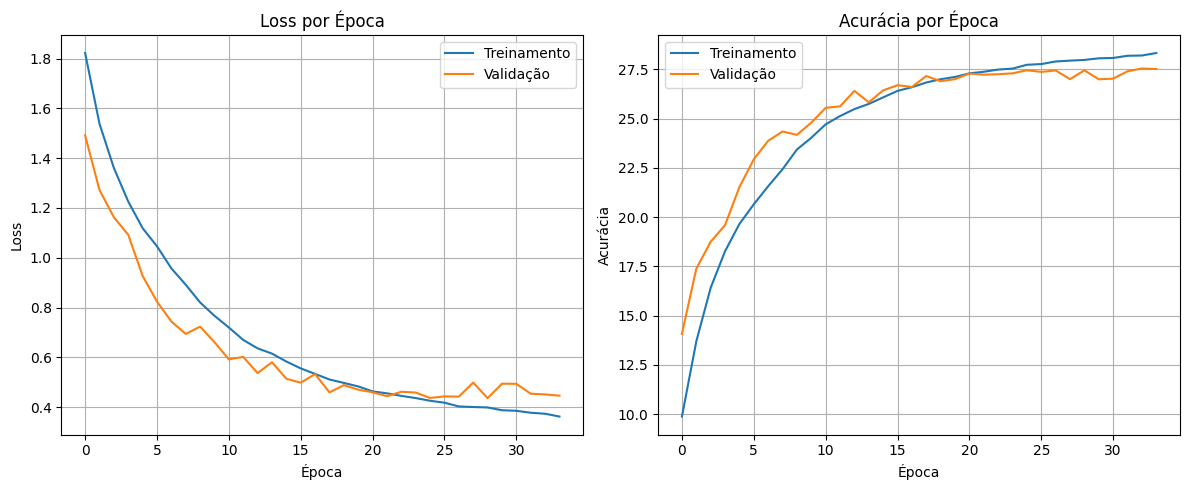

In [15]:
plotTrainVal(train_losses, val_losses, train_acc, val_acc)

In [16]:
targets, predictions = makePredictions(net, test_loader)

get_scores(targets, predictions)

{'accuracy': 0.8622,
 'balanced_accuracy': 0.8622,
 'precision': 0.8623562302910072,
 'recall': 0.8622,
 'f1_score': 0.8611766804091129}

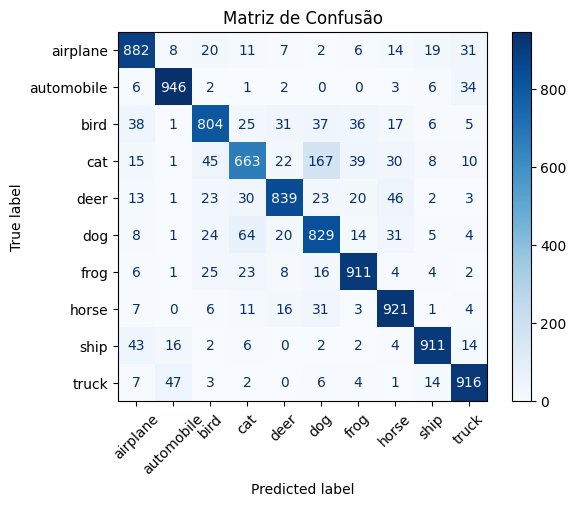

In [17]:
cm = confusion_matrix(targets, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

## Grad-cam

In [39]:
def show_cam_on_image(img):
    img = img.cpu()
    scores = net(img.unsqueeze(0))  # adiciona batch dimension

    # Extrair heatmap para a classe predita
    class_id = scores.argmax().item()
    activation_map = cam_extractor(class_id, scores)[0].cpu()

    img = img.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    heatmap = activation_map.squeeze().numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    resized_map = cv2.resize(heatmap, dsize=(32, 32), interpolation=cv2.INTER_LINEAR)

    resized_map = plt.cm.jet(resized_map)[..., :3]
    cam = resized_map * 0.5 + img * 0.5
    plt.imshow(cam)
    plt.axis('off')

In [40]:
net = CNN(arch=((1, 64), (2, 128), (2, 256)), batch_norm=True)
net.cpu()

net.load_state_dict(torch.load("best_model_exp2.pth", weights_only=True))

target_layer = net.feature_extractor[-1][0]  # <- último conv do último bloco
# GradCAM com essa camada
cam_extractor = GradCAM(net, target_layer=target_layer)

In [41]:
classes = test_dataset.classes

cat_imgs = []
# Itera sobre o dataset até encontrar uma imagem para cada uma das 10 classes
for img, label in test_dataset:
    class_name = classes[label]
    if class_name == 'cat':
        cat_imgs.append(img)
    # Para de procurar quando já tiver uma imagem de cada classe
    if len(cat_imgs) == 10:
        break

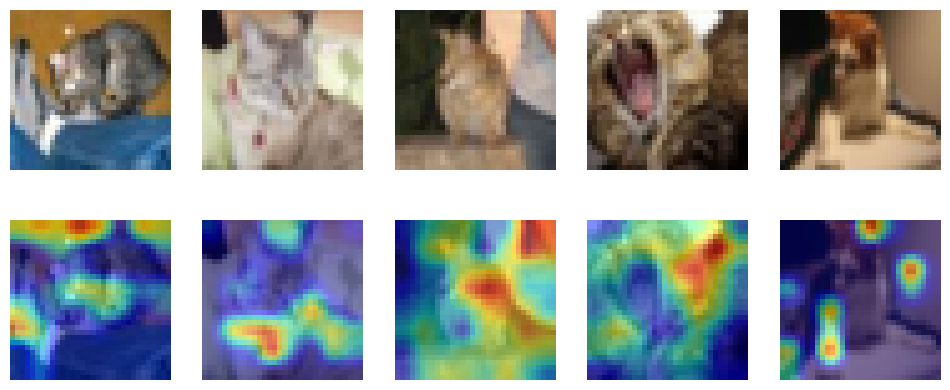

In [42]:
# Criar uma figura para exibir as imagens
fig = plt.figure(figsize=(12, 5))

# Exibe uma imagem para cada classe
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1) # Cria uma grade 2x5 de subplots
    img = cat_imgs[i%5]

    if i > 4:
        show_cam_on_image(img)
    else:
        imshow(img)


plt.show()

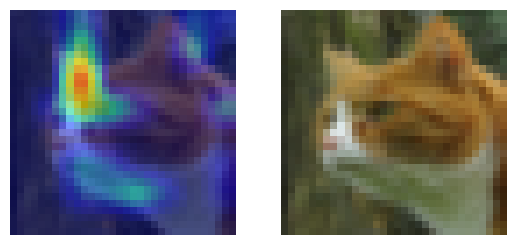

In [47]:
fig = plt.figure()

idx = 9

# Exibe uma imagem para cada classe
ax = fig.add_subplot(1, 2, 1)
show_cam_on_image(cat_imgs[idx])

ax = fig.add_subplot(1, 2, 2)
imshow(cat_imgs[idx])
